# Predicting concreteness of model generated explanations
Author: Katja Kamyshanova

-----------
The code below loads a regression model that predicts the concreteness scores for verbs, nouns, and adjectives in the generated explanations made by Qwen2-VL. The code that prepares the input and loads the model is adapted from Charbonnier and Wartena (2019). Please refer to their [paper](https://aclanthology.org/W19-0415/) and [GitHub page](https://github.com/textmining-hsh/Concreteness) for more information regarding the predictor input

Adjust the location to the necessary files to your preferred location. The regression model and all necessary data aside from the word2vec file can be found in the `concreteness` directory on our GitHub: https://github.com/katjaaaaaa/ms_thesis


In [ ]:
!pip install numpy==1.26.4
!pip install gensim==4.3.0
# !pip install gensim --no-binary :all:
# https://github.com/piskvorky/gensim/issues/3226#issuecomment-1525101465

  Using cached gensim-4.3.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.4 kB)
  Using cached FuzzyTM-2.0.9-py3-none-any.whl.metadata (7.9 kB)
  Using cached pyFUME-0.3.4-py3-none-any.whl.metadata (9.7 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 86.9 MB/s eta 0:00:00
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20431 sha256=76435b1462e01243a9655faaf0f5684e100d00525b69538f7af8db0e98779710
  Stored in directory: /root/.cache/pip/wheels/69/f5/e5/18ad

In [ ]:
import pickle
import io
import gensim
import nltk
import numpy as np
import pickle
import matplotlib.pyplot as plt

from collections import Counter

from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

from math import*
from nltk.stem.porter import *
from nltk.corpus import wordnet as wn

from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection  import KFold, cross_val_score
from sklearn import svm
from sklearn import datasets, linear_model, model_selection

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.spatial.distance import jaccard
from scipy.stats import kendalltau

model_name="ft"

feature_vector={
    "emb":True,
    "Suffix":True,
    "POS":True
}

In [ ]:
# Connect to drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
HEAD_DIR = "/content/gdrive/MyDrive/MS_postprocess_code"

# Load word2vec as input for the predictor

In [ ]:
def load_vectors(fname):
    reloaded_word_vectors = KeyedVectors.load_word2vec_format(fname)
    return reloaded_word_vectors

# Load pretrained word2vec model
model=load_vectors(f"{HEAD_DIR}/concreteness/data/crawl-300d-2M-subword.vec")


# Helper

In [ ]:
def getAllPostfix(s):
    if len(s)>3:
        return [s[-1:],s[-2:],s[-3:],s[-4:]]
    elif len(s)==3:
        return [s[-1:],s[-2:],s[-3:]]
    elif len(s)==2:
        return [s[-1:],s[-2:]]
    elif len(s)==1:
        return [s]
    else:
        return [""]

def getPostfixVec(s,mc,dim=100):
    vec=[0]*dim
    Post=getAllPostfix(s)
    for i in range(dim):
        if mc[i] in Post:
            vec[i]=1
    return vec

def getPorterVec(s,mc,dim=150):
    vec=[0]*dim
    Post=getPorterRest(s)
    for i in range(dim):
        if mc[i] == Post:
            vec[i]=1
    return vec

endingDir={}
endingList=[]

In [ ]:
stemmer = PorterStemmer()
def getPorterRest(s):
    stem=stemmer.stem(s)
    ret=""
    for k in range(len(s)-len(stem)):
        ret+=(s[len(stem)+k])
    return ret
porterList=[]

In [ ]:
def getVecFromPos(s):
    vec=[]
    if s=='a':
        vec=[1,0,0,0,0,0]
    if s=='n':
        vec=[0,1,0,0,0,0]
    if s=='p':
        vec=[0,0,1,0,0,0]
    if s=='r':
        vec=[0,0,0,1,0,0]
    if s=='s':
        vec=[0,0,0,0,1,0]
    if s=='v':
        vec=[0,0,0,0,0,1]
    return vec#np.asarray(vec)

In [ ]:
def getPos(w):
    poss=[]
    posSum=0
    posfreqs = {'n':0,'v':0,'a':0,'p':0,'r':0,'s':0}
    found=False
    for syns in wn.synsets(w):
        p = syns.pos()
        if p not in poss:
            poss.append(p)
        count = posfreqs.get(p,0)
        for l in syns.lemmas():
            count += l.count()
            if count>0:
                found=True
        posfreqs[p] = count
    if found:
        for fr in posfreqs:
            posSum+=posfreqs[fr]
        pos=[posfreqs['n']/posSum,posfreqs['v']/posSum,posfreqs['a']/posSum,posfreqs['p']/posSum,posfreqs['r']/posSum,posfreqs['s']/posSum]
    else:
        tags = nltk.pos_tag([w])
        tag = tags[0][1]
        if tag[0] == 'R':
            pos = 'r'
            pos=[0,0,0,0,1,0]
        elif tag[0] == 'J':
            pos = 'a'
            pos=[0,0,1,0,0,0]
        elif tag[0] == 'V':
            pos = 'v'
            pos=[0,1,0,0,0,0]
        elif tag == 'IN':
            pos = 'p'
            pos=[0,0,0,1,0,0]
        else:
            pos = 'n'
            pos=[1,0,0,0,0,0]
    return pos


def transformScale(old_value, old_min = 1, old_max = 7, new_min = 1, new_max = 5):
    new_value = ( (old_value - old_min) / (old_max - old_min) ) * (new_max - new_min) + new_min
    if new_value>new_max:
        print("new_value > max")
    return new_value

In [ ]:
def jaccard_similarity(x,y,verbose=0):

    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    if verbose>0:
        print("\n Intersection Cardinality: "+str(intersection_cardinality))
        print("Unity Cardinality: "+str(union_cardinality))
        print("\n")
    return intersection_cardinality/float(union_cardinality)


def getFeature(w,embeddingmodel=model,emb=True,POS=True,Post=True,verbose=0):
    emb=feature_vector["emb"]
    POS=feature_vector["POS"]
    Post=feature_vector["Suffix"]
    vect=[]
    vect=np.asarray(vect)
    if verbose>0:
        print(feature_vector)
    vect=np.append(vect,model[w])
    vect=np.append(vect,getPos(w))
    vect=np.append(vect,getPostfixVec(w,most_common_ending,dim=200))
    return vect

def getPrediction(vec,trained_model):
    return trained_model.predict([vec])

def get_r2_numpy_corrcoef(x, y):
    return np.corrcoef(x, y)[0, 1]**2

def getOwnR2(x,y):
    x=np.asarray(x)
    y=np.asarray(y)
    x_mean=x.mean()
    y_mean=y.mean()
    defined_var=0
    total_var=0
    undefined_var=0
    for i in range(len(y)):
        undefined_var+= (x[i]-y[i])**2
        defined_var += (y[i]-x_mean)**2
        total_var += (x[i]-x_mean)**2

    r2_val=defined_var/total_var
    r2_val2=1-(undefined_var/total_var)
    return r2_val,r2_val2


def evalModel(listA,listB,own=False,):
    r_score=r2_score(listA,listB)
    p_score=pearsonr(listA,listB)
    s_score=spearmanr(listA,listB)
    np_score=get_r2_numpy_corrcoef(listA,listB)
    mse_score=mean_squared_error(listA,listB)
    r2_o,r2_o2=getOwnR2(listA,listB)
    tau_score=kendalltau(listA,listB)
    if own:
        print("\n########  OWN  ###########\n")
        print(" r2: "+str(r2_o))
        print("own r2_2: "+str(r2_o2))
    print("\n######## CUSTOM ###########\n")
    print("Pearson: "+str(p_score))
    print("Kendall: "+str(tau_score))
    print("Spearman: "+str(s_score))
    print("Pearson**2: "+str(np_score))
    print("R^2 Score: "+str(r_score))
    print("MSE: "+str(mse_score))
    print("\n##########################\n")

# Prepare the input for Concreteness Predictor

In [ ]:
import json

def mt40k_mirage(f):
    words = []

    vectorDic={}
    concDic={}
    dat=[]
    tar=[]
    reg=[]
    std=[]
    tarstd=[]
    numKeyError=0
    raw=[]
    MT40K=[]
    MT40K_allWords=[]
    MT40KnoEmb=[]
    MT40K_twophrase=[]
    entries = []

    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger_eng')

    with open(f"{HEAD_DIR}/concreteness/data/{f}.json") as f:
        data_dict = json.load(f)
        for _, data in data_dict.items():
            for k in ("zero-shot", "few-shot"):
                if k not in data:
                    continue
                for vlm, answers in data[k].items():
                    if isinstance(answers, dict):
                        entries.append([k, vlm, answers["model_explanation"]])
                        words.append(answers["concreteness_words"])

    fout = open(f"{HEAD_DIR}/concreteness/data/concreteness_pos.txt", 'w')

    ######################
    CP_wordlist=[]
    TWP_wordlist=[]
    CPExt_wordlist=[]
    skipped_content=0
    for entry in words:
        dat_s, tar_s = [], []
        std_s, tarstd_s = [], []
        MT40K_s = []
        for w in entry:
            if int(w[1]) == 0:
                posfreqs = {}
                for syns in wn.synsets(w[0]):
                    p = syns.pos()
                    count = posfreqs.get(p,0)
                    for l in syns.lemmas():
                        count += l.count()
                    posfreqs[p] = count
                posfreqs = sorted(posfreqs.items(),key = lambda x:x[1],reverse = True)
                if len(posfreqs) > 0:
                    pos = posfreqs[0][0]
                else:
                    tags = nltk.pos_tag([w[0]])
                    tag = tags[0][1]
                    if tag[0] == 'R':
                        pos = 'r'
                    elif tag[0] == 'J':
                        pos = 'a'
                    elif tag[0] == 'V':
                        pos = 'v'
                    elif tag == 'IN':
                        pos = 'p'
                    elif tag[0] == 'N' and tag[:3] != "NNP":
                        pos = 'n'

                w1 = [w[0],pos]+w[1:]

                for wi in getAllPostfix(w[0]):

                    endingList.extend([wi])
                porterList.append(getPorterRest(w[0]))
                ########

                if w1[2]==0: #Bigramm=0 == only one word
                    corVal = w1[3]
                    corStd = w1[4] # these values are all 0
                    try:

                        #vectorDic[w1[0]]=model[w1[0]]
                        concDic[w1[0]]=corVal

                        #Feature Vector
                        vect=getFeature(w1[0],emb=True,POS=True,Post=True)

                        #Save for Eval
                        MT40K_s.append((w1[0],getPos(w1[0]),corVal,corStd)) #1=word,2=pos,3=conc,4=std

                        # Store each word in an array
                        dat_s.append(np.asarray(vect))
                        tar_s.append(float(corVal))
                        std_s.append(float(corStd))
                        tarstd_s.append([float(corVal),float(corStd)])
                        raw.append(w1)
                    except KeyError:
                        numKeyError+=1
                        MT40KnoEmb.append(w1[0])

        # Store each entry as an array
        MT40K.append(MT40K_s)
        dat.append(dat_s)
        tar.append(np.asarray(tar_s))
        std.append(np.asarray(std_s))
        tarstd.append(np.asarray(tarstd_s))

    fout.close()
    dat=np.asarray(dat, dtype="object")
    tar=np.asarray(tar, dtype="object")
    std=np.asarray(std, dtype="object")
    print("allWords: ",len(words))
    print("skipped_content: ",skipped_content)
    print("no embedding: ",numKeyError)
    print("\nMT40k:",len(MT40K))
    print("MT40k all 1-phrase words: ",len(MT40K_allWords))
    print("MT40k 2-Phrase: ",len(MT40K_twophrase))
    print("MT40k Union: ",len(MT40K_allWords)+len(MT40K_twophrase))

    return MT40K, dat, tar, std, tarstd, entries

In [ ]:
c_p =Counter(porterList).most_common(200)
c_e =Counter(endingList).most_common(200)

most_common_porter=[]
most_common_ending=[]
for t in c_p:
    most_common_porter.append(t[0])
for t in c_e:
    most_common_ending.append(t[0])

In [ ]:
with open(f'{HEAD_DIR}/concreteness/data/most_common_ending.pkl', 'rb') as f:
    most_common_ending = pickle.load(f)
with open(f'{HEAD_DIR}/concreteness/data/most_common_porter.pkl', 'rb') as f:
    most_common_porter = pickle.load(f)

# Predict the concreteness for the input files

In [ ]:
with open(f"{HEAD_DIR}/concreteness/Concreteness.model", "rb") as f:
    svr = pickle.load(f)

In [ ]:
from collections import defaultdict

def nested_dict():
    return defaultdict(nested_dict)

In [ ]:
input_files = [
            # "features_few-shot_5065_154_7879_2_5004_78_071436_28_06_2025_plo_test"
               "negation_features_true_positive",
               "negation_features_false_positive",
               "negation_features_true_negative",
               "negation_features_false_negative",
               ]

In [ ]:
for f in input_files:
    # Get the necessary for the regressor data
    MT40K, dat, tar, std, tarstd, entries = mt40k_mirage(f)
    c_dict = nested_dict()
    scores_list = []
    word_score_list = {}

    # Make predictions
    for entry in dat:
        scores_list.append(svr.predict(entry))
    print(f"-------FILENAME: {f}-------")

    # Evaluate predictions per model
    for i, entry in enumerate(MT40K):
        c_mean = []
        c_dict[entries[i][0]][entries[i][1]] = c_dict[entries[i][0]].get(entries[i][1], [])
        for g, w in enumerate(entry):
            c_mean.append(scores_list[i][g])
            word_score_list[w[0]] = scores_list[i][g]
        c_dict[entries[i][0]][entries[i][1]].append(np.mean(c_mean))

    for k, data in c_dict.items():
        print(f"PROMPT TYPE: {k}")
        for m, s in data.items():
            print(f"{m} CONCRETENESS MEAN: {np.mean(s)}")
        print()

    with open(f"{HEAD_DIR}/concreteness/data/{f}.json") as file:
            data_dict = json.load(file)
            for _, data in data_dict.items():
                for k in ("zero-shot", "few-shot"):
                    if k not in data:
                        continue
                    for vlm, answers in data[k].items():
                        if isinstance(answers, dict):
                            for i, w in enumerate(answers["concreteness_words"]):
                                if w[0] in word_score_list.keys():
                                    answers["concreteness_words"][i][2] = word_score_list[w[0]]

    print()

    with open(f"{HEAD_DIR}/specificity/data/{f}_concrete.json", "w") as file:
        json.dump(data_dict, file, indent=2)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


allWords:  2498
skipped_content:  0
no embedding:  38

MT40k: 2498
MT40k all 1-phrase words:  0
MT40k 2-Phrase:  0
MT40k Union:  0
-------FILENAME: features_few-shot_5065_154_7879_2_5004_78_071436_28_06_2025_plo_test-------
PROMPT TYPE: few-shot
Qwen/Qwen2-VL-7B-Instruct CONCRETENESS MEAN: 3.0434027319352075




## Get the average concreteness per input file

In [ ]:
from scipy.stats import skew, kurtosis
import json
import numpy as np

In [ ]:
for f in input_files:
    c_mean = []
    count_wrong_output_high = set()
    count_wrong_output_low = set()
    with open(f"{HEAD_DIR}/specificity/data/{f}_concrete.json") as file:
        data_dict = json.load(file)
    print(f"NUMBER OF ENTRIES: {len(data_dict)}")
    for _, data in data_dict.items():
        for k in ("zero-shot", "few-shot"):
            if k not in data:
                continue
            for vlm, answers in data[k].items():
                if isinstance(answers, dict):
                    for w in answers["concreteness_words"]:
                        if w[2] > 5:
                            count_wrong_output_high.add(w[0])
                            w[2] = 5
                        elif w[2] < 1:
                            count_wrong_output_low.add(w[0])
                            w[2] = 1
                        c_mean.append(w[2])

    # get_hist(f, c_mean)
    print(f"CONCRETENESS {f} MEAN: {round(np.mean(c_mean), 4)} SD: {round(np.std(c_mean), 4)}")
    print(f"SKEWNESS: {skew(c_mean)}")
    print(f"KURTOSIS: {kurtosis(c_mean)}")
    print(f"N WORDS WITH CONCRETENESS > 5: {len(count_wrong_output_high)}, WORDS: {count_wrong_output_high}")
    print(f"N WORDS WITH CONCRETENESS < 1: {len(count_wrong_output_low)}, WORDS: {count_wrong_output_low}")
    print()

NUMBER OF ENTRIES: 998
CONCRETENESS negation_features_true_positive MEAN: 3.0717 SD: 0.8095
SKEWNESS: 0.31664064108283896
KURTOSIS: -0.633771258499439
N WORDS WITH CONCRETENESS > 5: 68, WORDS: {'belt', 'rice', 'pizza', 'bone', 'van', 'casket', 'soap', 'knee', 'milk', 'hair', 'scarf', 'helmet', 'chair', 'steel', 'glass', 'farm', 'arm', 'crane', 'beard', 'wall', 'pink', 'drum', 'bike', 'sky', 'gown', 'cone', 'pie', 'head', 'hole', 'palm', 'tree', 'truck', 'gun', 'desk', 'box', 'wire', 'tin', 'rifle', 'roof', 'bird', 'ball', 'coffin', 'shirt', 'bag', 'red', 'coat', 'snow', 'bat', 'jawbone', 'crib', 'oil', 'bus', 'pipe', 'bed', 'dog', 'carpet', 'tv', 'lorry', 'spear', 'sash', 'burqa', 'turtle', 'gas', 'car', 'hat', 'boat', 'eel', 'tape'}
N WORDS WITH CONCRETENESS < 1: 7, WORDS: {'smartwatche', 'lgbtq+', 'mercede', 'longliste', 'longine', 'deceuninck', 'emptive'}

NUMBER OF ENTRIES: 217
CONCRETENESS negation_features_false_positive MEAN: 3.0361 SD: 0.8181
SKEWNESS: 0.3993014414611634
KURTOS

## Get the average concreteness for nouns, adjectives or verbs only

In [ ]:
# removing verbs from the mean
avg_mean = []
for f in input_files:
    adj_list, adj_conc_scores = [], []
    noun_list, noun_conc_scores = [], []
    avg_conc_score = []
    adj_mean = []
    noun_mean = []
    verb_mean = []
    with open(f"{HEAD_DIR}/specificity/data/{f}_concrete.json") as file:
        data_dict = json.load(file)
    for _, data in data_dict.items():
        for k in ("zero-shot", "few-shot"):
            if k not in data:
                continue
            for vlm, answers in data[k].items():
                if isinstance(answers, dict):
                    for w in answers["concreteness_words"]:
                        if w[2] >= 5:
                            w[2] = 5
                        elif w[2] <= 1:
                            w[2] = 1
                        if w[8] == "Adjective":
                            adj_mean.append(w[2])
                            avg_mean.append(w[2])
                            #print(f"ADJ {w[0]} SCORE {w[2]}")
                        elif w[8] == "Noun":
                            noun_mean.append(w[2])
                            #print(f"NOUN {w[0]} SCORE {w[2]}")
                            avg_mean.append(w[2])
                        elif w[8] == "Verb":
                            verb_mean.append(w[2])

    print(f"FILE: {f}")
    print(f"CONCRETENESS NOUN + ADJ: {round(np.mean(avg_mean), 4)} SD: {round(np.std(avg_mean), 4)} MEDIAN: {round(np.median(avg_mean), 4)} SKEWNESS: {skew(avg_mean)} KURTOSIS: {kurtosis(avg_mean)}")
    print(f"CONCRETENESS MEAN OF {len(noun_mean)} NOUN ONLY: {round(np.mean(noun_mean), 4)} SD: {round(np.std(noun_mean), 4)} MEDIAN: {round(np.median(noun_mean), 4)} SKEWNESS: {skew(noun_mean)} KURTOSIS: {kurtosis(noun_mean)}")
    print(f"CONCRETENESS MEAN {len(adj_mean)} ADJ ONLY: {round(np.mean(adj_mean), 4)} SD: {round(np.std(adj_mean), 4)} MEDIAN: {round(np.median(adj_mean), 4)} SKEWNESS: {skew(adj_mean)} KURTOSIS: {kurtosis(adj_mean)}")
    print(f"CONCRETENESS MEAN OF {len(verb_mean)} VERB ONLY: {round(np.mean(verb_mean), 4)} SD: {round(np.std(verb_mean), 4)} MEDIAN: {round(np.median(verb_mean), 4)} SKEWNESS: {skew(verb_mean)} KURTOSIS: {kurtosis(verb_mean)}")
    print()

FILE: negation_features_true_positive
CONCRETENESS NOUN + ADJ: 3.2521 SD: 0.8329 MEDIAN: 3.3757 SKEWNESS: 0.011225970479461549 KURTOSIS: -0.7114314138725937
CONCRETENESS MEAN OF 11705 NOUN ONLY: 3.5101 SD: 0.6898 MEDIAN: 3.5626 SKEWNESS: 0.09564130932329733 KURTOSIS: -0.381653349394778
CONCRETENESS MEAN 3692 ADJ ONLY: 2.4342 SD: 0.7103 MEDIAN: 2.0859 SKEWNESS: 1.3687570409526078 KURTOSIS: 1.42604093740972
CONCRETENESS MEAN OF 6666 VERB ONLY: 2.6549 SD: 0.5633 MEDIAN: 2.541 SKEWNESS: 0.7217169110379024 KURTOSIS: 0.4363466058880694

FILE: negation_features_false_positive
CONCRETENESS NOUN + ADJ: 3.2509 SD: 0.8339 MEDIAN: 3.3757 SKEWNESS: 0.0210197971631061 KURTOSIS: -0.7191954775787388
CONCRETENESS MEAN OF 2489 NOUN ONLY: 3.5017 SD: 0.7077 MEDIAN: 3.5626 SKEWNESS: 0.09270036368074026 KURTOSIS: -0.46809846564893487
CONCRETENESS MEAN 796 ADJ ONLY: 2.4424 SD: 0.6952 MEDIAN: 2.1546 SKEWNESS: 1.4293423542178614 KURTOSIS: 1.758430051076063
CONCRETENESS MEAN OF 1518 VERB ONLY: 2.584 SD: 0.5461 

## Plot the concreteness score distribution

In [ ]:
import matplotlib.pyplot as plt

def get_hist(f, score_list, score_list2=None, extra=None):
    f_name = " ".join(f.split("_")[-2:]).capitalize()
    if extra is not None:
        f_name = f"{f_name} {extra}"

    if score_list2 is None:
        # Single dataset
        plt.figure(figsize=(7, 5))
        plt.hist(score_list, bins=10, edgecolor='white', alpha=0.8)
    else:
        # Two datasets
        plt.figure(figsize=(10, 7))
        plt.hist([score_list, score_list2], bins=10,
                 label=['Noun', 'Adjective'],
                 edgecolor='white', alpha=0.6, histtype='stepfilled')
        plt.legend()

    plt.xlabel("Concreteness", fontsize=10)
    plt.ylabel("Number of words", fontsize=10)
    plt.title(f"{f_name} Concreteness Score Distribution", fontsize=15)
    plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)

    plt.savefig(f"{HEAD_DIR}/concreteness/concreteness_{f}.pdf",bbox_inches="tight")
    plt.show()


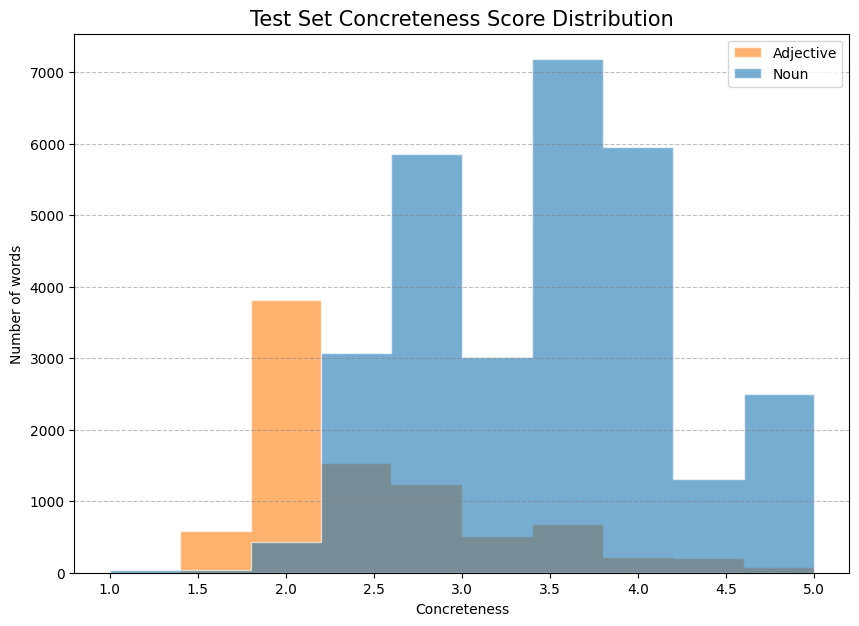

In [ ]:
get_hist(f, noun_mean, adj_mean)